In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats as st
import os

## First, do a threshold scan on the recorded October 12-13 snapshot data.

In [56]:
Nsnapshot=1440
fbins=np.linspace(0,197/2,int(1+4096/2))
timebins = (1/60)*np.asarray(range(Nsnapshot))

#basename='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/cosmic_ray_backup/snapshots/24hour_scan10-12-2021/'
#fnames=os.listdir(basename)
#above is commented out because it returns the file names in the wrong order
with open("/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/cosmic_ray_backup/snapshots/ls24hour_scan10-12-2021.txt") as f:
    fnames=f.readlines()
basename="/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/cosmic_ray_backup/snapshots/24hour_scan10-12-2021/"
print(fnames[0])

single_board_snapshot1634064473.0826933.npy



In [66]:
Nchan=2049
Nant = 64


dynamicspectra=np.zeros((Nchan,Nsnapshot,Nant))
maxtimeseries =np.zeros((Nsnapshot,Nant))
    
for j in range(Nsnapshot):
    #fname=fnames[j]
    fname=fnames[j][:-1]

    snapshot=np.load(basename+fname)
    for i in range(Nant):
        timeseries = snapshot[:,i+4]
        maxtimeseries[j,i]=np.max(np.abs(timeseries))
        spec=np.fft.rfft(timeseries)
        logpower = np.log(np.square(np.abs(spec)))
        dynamicspectra[:,j,i] = logpower

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


1440


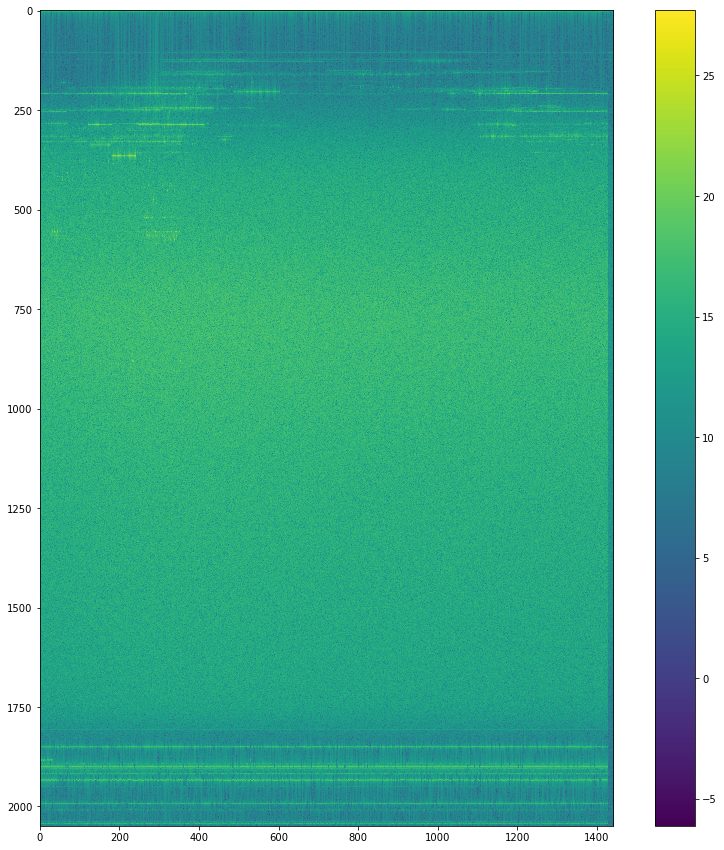

In [67]:
print(Nsnapshot)
plt.figure(figsize=(15,15))
plt.imshow(dynamicspectra[:,:,0],interpolation='None')
plt.colorbar()
plt.show()

In [65]:
print(np.max(maxtimeseries))

184.0


## First snapshot

In [5]:
fname=fnames[0][:-1]
snapshot=np.load(basename+fname)
timeseries = snapshot[:,i+4]


#### Plot first snapshot, one antenna

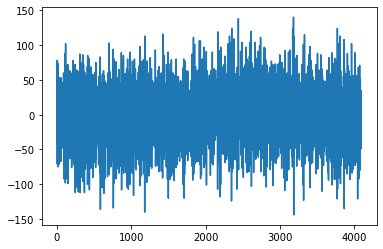

In [6]:
plt.plot(timeseries)

#### Work to calculate threshold scan, testing on small part of timeseries

[ 14.   1.   7.  78.  24. -71. -23.  -2.   5. -43.]
5


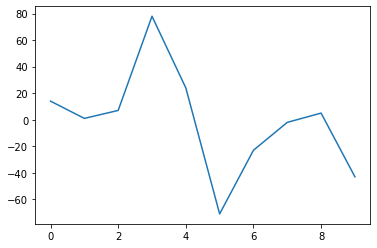

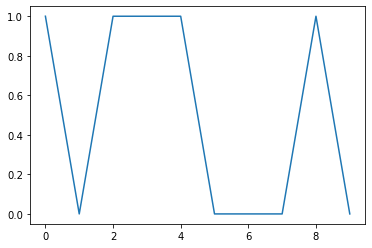

In [7]:
thresh=4
testtimeseries=timeseries[:10]
plt.plot(testtimeseries)
threshexcess= testtimeseries > thresh
plt.figure()
plt.plot(threshexcess)
print(testtimeseries)
print(np.sum(threshexcess))


####  Calculate threshold scan for one snapshot, all antennas

In [17]:
thresholds1=4*np.asarray(range(256))
threshscan1=np.zeros((Nant,len(thresholds1)))
for i in range(Nant):
        timeseries = snapshot[:,i+4]
        sqtimeseries=np.square(timeseries)
        for t, thresh in enumerate(thresholds1):
            threshexcess= sqtimeseries > thresh**2
            threshscan1[i,t]+=np.sum(threshexcess)



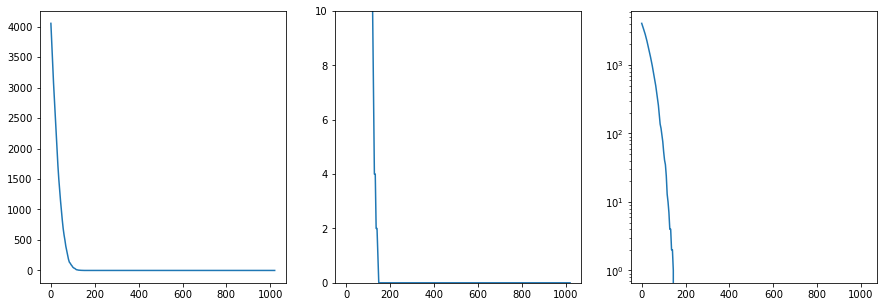

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(thresholds1,threshscan1[0,:])
plt.subplot(132)
plt.plot(thresholds1,threshscan1[0,:])
plt.ylim((0,10))
plt.subplot(133)
plt.semilogy(thresholds1,threshscan1[0,:])



#### Threshold scan on full set of snapshots


In [90]:
def dothreshscan(basedir,filenames,thresholdlist):
    #Function to calculate the number of times each the absolute value of the voltage in each antenna's timeseries exceeded each threshold
    #results are returned in an array whose dimensions are the number of antennas and the number of thresholds
    #input voltage timeseries are provided from snapshot array numpy files.  
    #Threshold excess counts are combined for all the timeseries data for each antenna, combining counts across files.
    #Separate antennas are treated separately.
    #basedir is the path to the direcory that contains the snapshot files
    #filenames is a list of snapshot files to include in the threshold scan
    #thresholds is an array or list of thresholds to use for the scan
    Nant=64
    Nsnapshot=len(filenames)
    threshscan=np.zeros((Nant,len(thresholdlist)))
    for j in range(Nsnapshot):
        fname=filenames[j]
        snapshot=np.load(basedir+fname)
        for i in range(Nant):
            timeseries = snapshot[:,i+4]
            maxtimeseries[j,i]=np.max(np.abs(timeseries))
            sqtimeseries=np.square(timeseries)
            for t, thresh in enumerate(thresholdlist):
                threshexcess= sqtimeseries > thresh**2
                threshscan[i,t]+=np.sum(threshexcess)
    return threshscan

##### 1. Coarse Threshold scan

In [92]:
filenames=[f[:-1] for f in fnames]
threshscan=dothreshscan(basename,filenames,[128,150,200,250,350,500,511])

Text(0, 0.5, 'antenna index')

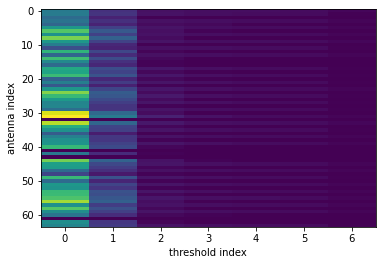

In [93]:
plt.imshow(threshscan,aspect='auto')
plt.xlabel('threshold index')
plt.ylabel('antenna index')

In [94]:
print(np.max(threshscan[:,6]))
print(np.max(maxtimeseries))

1592.0
512.0


##### 2. Detailed threshold scan

In [95]:
threshscan2=dothreshscan(basename,filenames,4*np.asarray(range(128)))

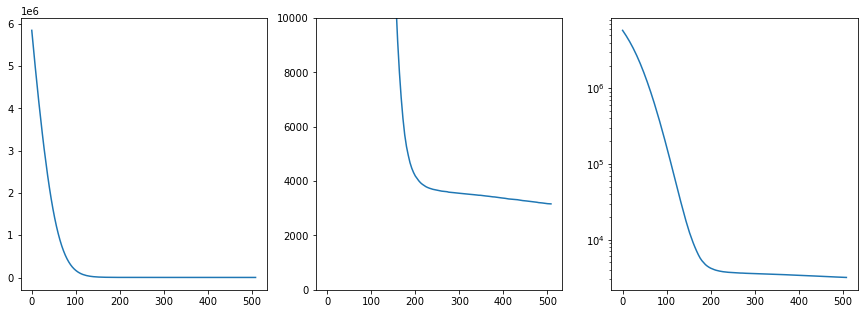

In [104]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(4*np.asarray(range(128)),threshscan2[0,:])
plt.subplot(132)
plt.plot(4*np.asarray(range(128)),threshscan2[0,:])
plt.ylim((0,1e4))
plt.subplot(133)
plt.semilogy(4*np.asarray(range(128)),threshscan2[0,:])


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


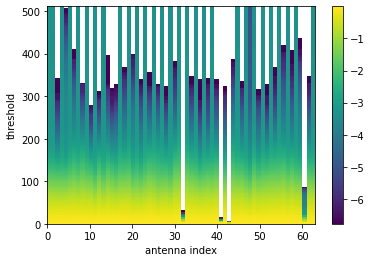

In [115]:
plt.imshow(np.log10(threshscan2.transpose()/(Nsnapshot*4096)),aspect='auto',interpolation='None', origin='lower',extent=(0,63,0,511))
plt.ylabel('threshold')
plt.xlabel('antenna index')
plt.colorbar()

## Code to apply simple FIR

In [136]:
def fir(coefficients, signal):
    #Filter input signal with the FIR described by the input coefficients
    #both inputs are 1D numpy arrays
    ntaps=len(coefficients)
    out=np.zeros(len(signal)-ntaps)
    for n in range(ntaps):
        tap=coefficients[n]*signal[ntaps-n:len(signal)-n]
        out+=tap
        #print(tap)
    return out

### Use simple moving window average to test that it works as expected

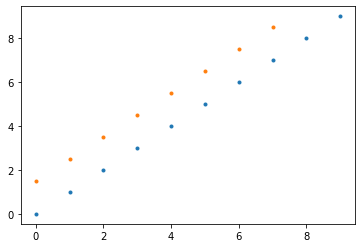

In [146]:
test=np.asarray(range(10))
coeffs=[0.5,0.5]
plt.plot(test,'.')
plt.plot(fir(coeffs,test),'.')

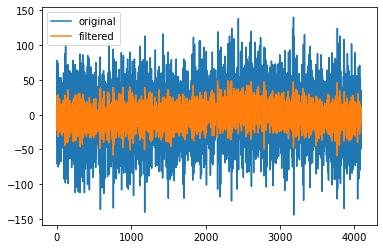

In [147]:
fname=fnames[0][:-1]
coeffs=[0.25,0.25,0.25,0.25]

snapshot=np.load(basename+fname)
timeseries = snapshot[:,i+4]
plt.plot(timeseries,label='original')
plt.plot(fir(coeffs,timeseries),label='filtered')
plt.legend()
#plt.xlim(1000,1020)